# BÀI THỰC HÀNH 1 – GIẢI THUẬT 2 (SVM)  
**Bài toán:** Dự đoán bệnh tiểu đường

## 1. Mục tiêu

- Áp dụng giải thuật **Máy vector hỗ trợ (Support Vector Machine – SVM)** cho bài toán phân lớp bệnh tiểu đường.  
- So sánh kết quả của SVM với các mô hình **Cây quyết định** và **Random Forest** đã xây dựng ở Giải thuật 1.  
- Thực hành quy trình: tiền xử lý dữ liệu, chuẩn hoá đặc trưng, huấn luyện SVM và đánh giá mô hình.

---

# 1. Import thư viện

In [1]:
# 1. Import thư viện
# ======================================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 2. Đọc dữ liệu

In [2]:
# ======================================================
# 2. Đọc dữ liệu
# ======================================================

df = pd.read_csv("diabetes_prediction_dataset.csv")

print("Kích thước dữ liệu:", df.shape)
df.head()


Kích thước dữ liệu: (100000, 9)


gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Thống kê mô tả các cột số:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26

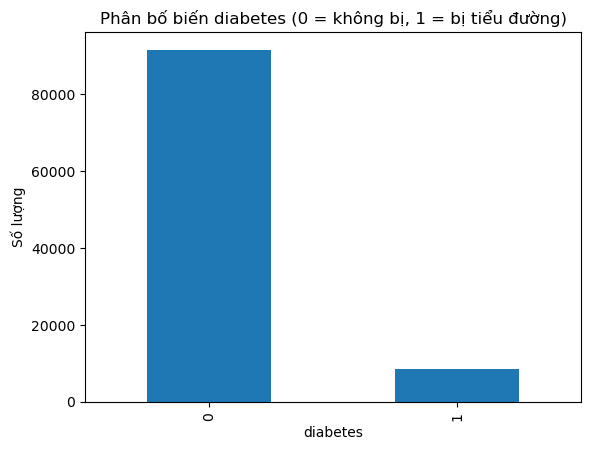

In [3]:
# (tuỳ chọn) Khám phá nhanh lại cho bài SVM
print(df.info())
print("\nThống kê mô tả các cột số:")
print(df.describe())

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())

# Phân bố nhãn
df['diabetes'].value_counts().plot(kind='bar')
plt.title("Phân bố biến diabetes (0 = không bị, 1 = bị tiểu đường)")
plt.xlabel("diabetes")
plt.ylabel("Số lượng")
plt.show()


## Khám phá & tiền xử lý dữ liệu (tóm tắt)

Dữ liệu dùng lại là **Diabetes Prediction Dataset** (100 000 mẫu, 9 cột):

- `gender`, `age`, `hypertension`, `heart_disease`,  
- `smoking_history`, `bmi`, `HbA1c_level`, `blood_glucose_level`,  
- `diabetes` (0: không bệnh, 1: tiểu đường).

Kết quả `info()` cho thấy:

- Không có giá trị thiếu ở bất kỳ cột nào.
- Các cột số (`age`, `bmi`, `HbA1c_level`, `blood_glucose_level`) kiểu `float64`.
- Các cột phân loại (`gender`, `smoking_history`) kiểu `object`.

Phân bố nhãn `diabetes` rất **bất cân bằng**: số người **không mắc bệnh (0)** chiếm phần lớn, số người **mắc bệnh (1)** ít hơn nhiều.


# 3. Chọn thuộc tính & Tiền xử lý

In [4]:
# ======================================================
# 3. Chọn thuộc tính & Tiền xử lý
# ======================================================

features = [
    'gender',
    'age',
    'hypertension',
    'heart_disease',
    'smoking_history',
    'bmi',
    'HbA1c_level',
    'blood_glucose_level'
]
target = 'diabetes'

X = df[features].copy()
y = df[target].copy()

# 3.1. (Phòng hờ) xử lý thiếu: bộ này thực tế không thiếu nhưng cứ fill cho chắc
for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    X[col] = X[col].fillna(X[col].median())

for col in ['gender', 'smoking_history']:
    X[col] = X[col].fillna(X[col].mode()[0])

# 3.2. One-hot encoding cho biến phân loại
X_encoded = pd.get_dummies(X, columns=['gender', 'smoking_history'], drop_first=True)

print("Các cột sau khi mã hoá:")
print(X_encoded.columns)
X_encoded.head()


Các cột sau khi mã hoá:
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current'],
      dtype='object')


age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   gender_Male  gender_Other  smoking_history_current  smoking_history_ever  \
0        False         False                    False                 False   
1        False         False                    False                 False   
2         True         False                    False                 False   
3        False         False                     True                 False   
4         True         False                     True                 False   

   smoking_history_former  smoking_history_never  smoking_history_not current  
0                   False                   True                        False  
1                   False                  False                        False  
2                   False                   True                        False  
3                   False                  False                        False  
4                   False                  False                        False

## Tiền xử lý

- Chọn các cột trên làm **features**, `diabetes` làm **label**.
- (Phòng hờ) điền thiếu:
  - Các cột số: dùng **median**.
  - Các cột phân loại: dùng **mode**.
- Mã hoá `gender` và `smoking_history` bằng **one-hot encoding** (`get_dummies`, `drop_first=True`).

# 4. Chia dữ liệu train/test

In [5]:
# ======================================================
# 4. Chia dữ liệu train/test
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Kích thước tập train:", X_train.shape)
print("Kích thước tập test :", X_test.shape)


Kích thước tập train: (80000, 13)
Kích thước tập test : (20000, 13)


- Chia dữ liệu:
  - Train: 80 000 mẫu
  - Test: 20 000 mẫu  
  với `train_test_split(test_size=0.2, random_state=42, stratify=y)`.

# 5. Xây dựng mô hình SVM (RBF kernel)
- Dùng Pipeline gồm StandardScaler + SVC
- class_weight='balanced' để xử lý mất cân bằng lớp

In [6]:
# ======================================================
# 5. Xây dựng mô hình SVM (RBF kernel)
#    - Dùng Pipeline gồm StandardScaler + SVC
#    - class_weight='balanced' để xử lý mất cân bằng lớp
# ======================================================

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced'
    ))
])

# Huấn luyện
svm_clf.fit(X_train, y_train)

# Dự đoán
y_pred_svm = svm_clf.predict(X_test)

# Đánh giá
print("========== SVM (RBF kernel) ==========")
print("Accuracy trên tập test:", round(accuracy_score(y_test, y_pred_svm), 4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification report:")
print(classification_report(y_test, y_pred_svm))


========== SVM (RBF kernel) ==========
Accuracy trên tập test: 0.8962

Confusion matrix:
[[16371  1929]
 [  146  1554]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18300
           1       0.45      0.91      0.60      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.90      0.77     20000
weighted avg       0.94      0.90      0.91     20000



### Cấu hình

Do SVM nhạy với thang đo của dữ liệu, mô hình được xây dựng bằng **Pipeline** gồm:

1. `StandardScaler` – chuẩn hoá các feature về trung bình 0, phương sai 1.  
2. `SVC` (Support Vector Classifier) với tham số:
   - `kernel = 'rbf'` (kernel Gaussian/RBF),
   - `C = 1.0`,
   - `gamma = 'scale'`,
   - `class_weight = 'balanced'` để bù lại sự mất cân bằng giữa lớp 0 và lớp 1.

Mô hình được huấn luyện trên tập train và đánh giá trên tập test.

### Confusion matrix

\[
\begin{bmatrix}
16371 & 1929 \\
146 & 1554
\end{bmatrix}
\]

Giải thích:

- **TN = 16371**: người **không tiểu đường** được dự đoán đúng là không bệnh.  
- **FP = 1929**: người **không tiểu đường** nhưng bị dự đoán nhầm là có bệnh.  
- **FN = 146**: người **có tiểu đường** nhưng bị dự đoán nhầm là không bệnh.  
- **TP = 1554**: người **có tiểu đường** được dự đoán đúng là có bệnh.

### Classification report

- **Lớp 0 – Không tiểu đường**
  - Precision: **0.99**
  - Recall: **0.89**
  - F1-score: **0.94**
  - Support: 18 300

- **Lớp 1 – Tiểu đường**
  - Precision: **0.45**
  - Recall: **0.91**
  - F1-score: **0.60**
  - Support: 1 700

- **Accuracy chung:** 0.90 (~ 89.62%)  
- **Macro average:** Precision 0.72 – Recall 0.90 – F1 0.77  
- **Weighted average:** Precision 0.94 – Recall 0.90 – F1 0.91


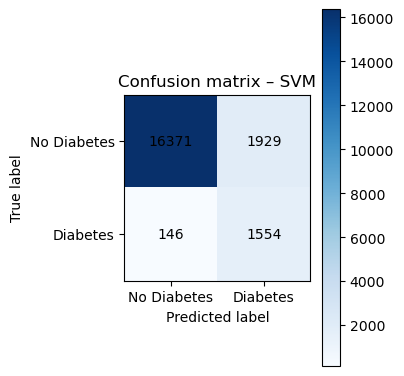

In [7]:
# (Tuỳ chọn) Vẽ confusion matrix dạng heatmap cho đẹp báo cáo

from matplotlib import ticker

cm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap="Blues")

ax.set_title("Confusion matrix – SVM")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No Diabetes", "Diabetes"])
ax.set_yticklabels(["No Diabetes", "Diabetes"])

# ghi số lên từng ô
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

fig.colorbar(im, ax=ax, format=ticker.ScalarFormatter())
plt.tight_layout()
plt.show()


In [8]:
# (Tuỳ chọn) So sánh nhanh với kết quả Decision Tree / Random Forest trước đó
# (nếu bạn còn các biến acc_dt, acc_rf từ notebook Giải thuật 1 thì dùng luôn;
#  nếu không thì comment 2 dòng đó lại và tự in thủ công)

# print(f"Accuracy Decision Tree (BT2, GT1): {acc_dt:.4f}")
# print(f"Accuracy Random Forest (BT2, GT1): {acc_rf:.4f}")
print(f"Accuracy SVM (BT1, GT2): {accuracy_score(y_test, y_pred_svm):.4f}")


Accuracy SVM (BT1, GT2): 0.8962


### Độ chính xác tổng thể

- **Accuracy của SVM trên tập test:** `0.8962`  ≈ **89.62%**


## So sánh với Decision Tree & Random Forest (Giải thuật 1)

Kết quả trước đó trên cùng bộ dữ liệu:

- **Decision Tree**: Accuracy ≈ **97.23%**  
  - FN ~ 554, FP = 0
- **Random Forest**: Accuracy ≈ **97.05%**  
  - FN ~ 530, FP = 61
- **SVM (RBF, balanced)**: Accuracy ≈ **89.62%**  
  - FN = 146, FP = 1929

So sánh:

- Về **Accuracy**, SVM thấp hơn rõ rệt so với 2 mô hình cây.  
- Tuy nhiên, về **khả năng phát hiện người mắc bệnh (Recall lớp 1)**:
  - SVM: **0.91**
  - Decision Tree: ~0.67
  - Random Forest: ~0.69

=> Nếu mục tiêu là **không bỏ sót bệnh nhân tiểu đường**, SVM với `class_weight='balanced'` là lựa chọn hợp lý hơn (ít FN).  
Ngược lại, nếu ưu tiên **độ chính xác tổng thể** và muốn hạn chế cảnh báo nhầm cho người khoẻ, các mô hình cây (Decision Tree/Random Forest) phù hợp hơn.

---

# Kết luận

- Bài thực hành đã áp dụng thành công giải thuật **SVM (RBF kernel)** cho bài toán dự đoán tiểu đường.  
- SVM cho Accuracy khoảng **89.62%**, thấp hơn Decision Tree/Random Forest nhưng **Recall lớp bệnh rất cao (0.91)**, giúp giảm số lượng bệnh nhân bị bỏ sót.  
- Việc lựa chọn mô hình phụ thuộc vào mục tiêu thực tế:
  - Nếu ưu tiên phát hiện tối đa bệnh nhân → SVM (hoặc các mô hình ưu tiên Recall) là lựa chọn tốt.  
  - Nếu ưu tiên độ chính xác tổng thể và giảm cảnh báo nhầm → có thể dùng Random Forest/Decision Tree.

Trong tương lai có thể cải thiện:
- Tinh chỉnh thêm siêu tham số `C`, `gamma` cho SVM (GridSearchCV).  
- Kết hợp với các kỹ thuật xử lý mất cân bằng lớp (SMOTE, oversampling/undersampling).  
- So sánh thêm với các thuật toán khác như Logistic Regression, XGBoost, v.v.
